# 10b. Core photo preparation U1313
This step is necessary because the photos are a bit too large to play with in these notebooks, in the 1-5 MB range. Many of these notebooks include lots of photos of cores, so if they are too big, the memory on my little MacBook Air gets overwhelmed. Also, I rotate them in this step so if all I want to do is make a simple plot with the core, I won't need to rotate them again. 

## Setup
### Import Packages

In [1]:
import pandas as pd
from IPython.display import clear_output
import time
import cv2 as cv
from scipy import interpolate
import os
import matplotlib.pyplot as plt
import numpy as np

### File Paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
core_photos='/Volumes/SanDisk.Data/IODP1313CorePhotos/'
cropped_path='/Volumes/SanDisk.Data/IODP1313CorePhotos/Cropped/'
lowres_path='/Volumes/SanDisk.Data/IODP1313CorePhotos/LowRes/Raw/'
medres_path='/Volumes/SanDisk.Data/IODP1313CorePhotos/MedRes/'

### Import Splice Info

In [4]:
splice=pd.read_csv(data_path+'SpliceTables/spliceConstruction1313.csv')
splice['CoreLabel']=(splice['Site'].map(str)+splice['Hole Start'].map(str).str.strip()+
                     '_'+splice['Core Start'].map(str))
splice['Top CoreLabel']=(splice['Site'].map(str)+splice['Hole End'].map(str).str.strip()+
                         '_'+splice['Core End'].map(str))
splice['Sec. Start']=splice['Sec. Start'].astype(str)
splice['Sec. End']=splice['Sec. End'].astype(str)

section_list=pd.read_csv(data_path+'SectionSummaries/sectionSummary1313.csv')
section_list=section_list.rename(columns={'H':'Hole','Cor':'Core','T':'Type','   Sc':'Section'})
section_list['SectionLabel']=(section_list['Site'].map(str)+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+
                              section_list['Section'].map(str))
section_list['CoreLabel']=(section_list['Site'].map(str)+section_list['Hole']+'_'+
                           section_list['Core'].astype(int).map(str))

### Create List of Splice Sections

In [5]:
sections=[]
core=splice.loc[0,'CoreLabel']
coredf=section_list[section_list['CoreLabel']==core]
i1=coredf.index.min()
i2=coredf[coredf['Section']==splice.loc[0,'Sec. Start']].index.values[0]
entries=coredf.loc[i1:i2,'SectionLabel'].tolist()
sections.append(entries)
for i in splice.index[1:]:
    core=splice.loc[i,'CoreLabel']
    coredf=section_list[section_list['CoreLabel']==core]
    i1=coredf[coredf['Section']==splice.loc[i-1,'Sec. End']].index.values[0]
    i2=coredf[coredf['Section']==splice.loc[i,'Sec. Start']].index.values[0]
    entries=coredf.loc[i1:i2,'SectionLabel'].tolist()
    sections.append(entries)
sections = [item for sublist in sections for item in sublist]

In [6]:
splice_sections=section_list.set_index('SectionLabel').loc[sections]
splice_sections['Bottom(mbsf)']=splice_sections['Top(mbsf)']+splice_sections['CL(m)']

### Reformat splice table

In [7]:
splicecores=splice['CoreLabel'].unique()

In [8]:
meta=splice.loc[0,['Leg', 'Site']].tolist() ## Leg, Site
sortkey=[int(0)] #Sort Key
nans=[None,None,None,None,None,None,None,None] # Hole & Core Start, CT, Sec,Int,MBSF&MCD Start, Rel
firstcore=splice.loc[0,['Hole Start', 'Core Start', 'CT','Sec. Start']].tolist() # Hole & Core End, CT, Sec End
zeros=[0,0,0] # Int End, MBSF & MCD End
corelabels=['',splice.loc[0,'CoreLabel']] # Top CoreLabel
splice.loc[-1,splice.columns]=meta+sortkey+nans+firstcore+zeros+corelabels
splice=splice.sort_index()

In [9]:
topcols=['Leg','Site','Sort Key','Hole End','Core End','CT.1','Sec. End','Int. End','MBSF End','MCD End']
botcols=['Sec. Start','Int. Start','MBSF Start','MCD Start']

In [10]:
tops=splice.set_index('Top CoreLabel').iloc[:-1]
bots=splice.set_index('CoreLabel').iloc[1:]

In [11]:
new_splice=pd.DataFrame(columns=[topcols+botcols])
for i,core in enumerate(tops.index):
    new_splice.loc[splicecores[i],topcols]=tops.loc[core,topcols].values
for i,core in enumerate(bots.index):
    new_splice.loc[splicecores[i],botcols]=bots.loc[core,botcols].values
new_splice=new_splice.rename(columns={'Hole End':'Hole',
                                     'Core End':'Core',
                                     'CT.1':'Type',
                                     'Sec. End':'Top section',
                                     'Int. End':'Top Offset (cm)',
                                     'Sec. Start':'Bottom section',
                                     'Int. Start':'Bottom Offset (cm)',
                                     'MBSF End':'Top MBSF (m)',
                                     'MCD End':'Top MCD (m)',
                                     'MBSF Start':'Bottom MBSF (m)',
                                     'MCD Start':'Bottom MCD (m)'})
new_splice.columns=new_splice.columns.get_level_values(0)

In [12]:
for sect in splice_sections[:-4].index:
    core=splice_sections.loc[sect,'CoreLabel']
    mbsfs=new_splice.loc[core,['Top MBSF (m)','Bottom MBSF (m)']].values
    mcds=new_splice.loc[core,['Top MCD (m)','Bottom MCD (m)']].values
    f=interpolate.interp1d(mbsfs,mcds,bounds_error=False,fill_value='extrapolate')
    splice_sections.loc[sect,'Top(mcd)']=f(splice_sections.loc[sect,'Top(mbsf)'])
    splice_sections.loc[sect,'Bottom(mcd)']=f(splice_sections.loc[sect,'Bottom(mbsf)'])

In [13]:
col_list=['Leg','Site','Core']

In [14]:
new_splice[col_list]=new_splice[col_list].astype(int)
first_core=new_splice.index[0]
new_splice.loc[first_core,'Top section']=1
new_splice=new_splice.drop('Sort Key',axis=1)

In [15]:
new_splice.to_csv(data_path+'SpliceTables/cleanSpliceConstruction1313.csv',index=False)

## Prep core photos
### Make splice sections list

In [16]:
files=os.listdir(core_photos+'Raw/')

In [17]:
for sect in splice_sections.index:
    subs=sect[:4]+sect[4].lower()+'_'+sect.split('_')[1].split('H')[0].zfill(3)+'h_'+sect.split('H')[1].zfill(2)
    splice_sections.loc[sect,'Filename']=str([i for i in files if subs in i])
nophotos=splice_sections[splice_sections['Filename']=='[]'].index
splice_sections=splice_sections.drop(nophotos,axis=0)
splice_sections['Filename']=splice_sections['Filename'].str[2:-2].astype(str)

In [19]:
splice_sections.to_csv(data_path+'SectionSummaries/spliceSections1313.csv')

### Crop photos
There's a ruler and sometimes little black space

In [20]:
test_sect_num=180

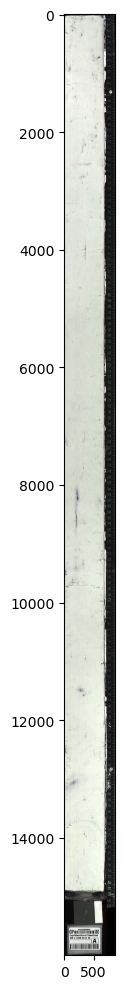

In [21]:
test_path=splice_sections['Filename'].iloc[test_sect_num]
test_section=cv.imread(core_photos+'Raw/'+test_path,1)
core_length=splice_sections['CL(m)'].iloc[test_sect_num]
rgb_section=cv.cvtColor(test_section,cv.COLOR_BGR2RGB)
fig,ax=plt.subplots(figsize=(8,10))
ax.imshow(rgb_section)
plt.tight_layout()

#### Binary Threshold

In [22]:
label_threshold=100
ruler_threshold=50

In [993]:
grey=cv.cvtColor(test_section, cv.COLOR_BGR2GRAY)
ret,blacks = cv.threshold(grey,50,255,cv.THRESH_BINARY_INV)

width_intensity=blacks.mean(axis=0)/255*100
    
wherearr=np.where(width_intensity>ruler_threshold)[0]
wherearr_diff=wherearr[1:]-wherearr[:-1]
if len(np.where(wherearr_diff>400)[0])>=1:
    right_split=np.where(wherearr_diff>400)[0][-1]+1
    left_split=np.where(wherearr_diff>400)[0][0]
    core_left=wherearr[left_split]
    core_right=wherearr[right_split]
else:
    core_right=wherearr[0]
    core_left=0

#### Use blacks to remove ruler and anything left on bottom

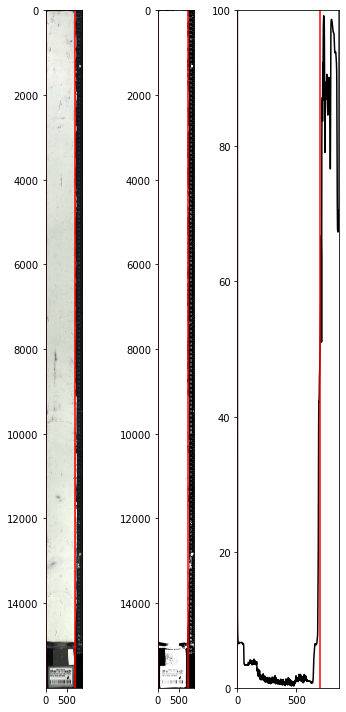

In [994]:
fig,axes=plt.subplots(figsize=(5,10),ncols=3)
axes[0].imshow(rgb_section)
axes[0].axvline(core_right,color='r')
axes[0].axvline(core_left,color='r')

axes[1].imshow(blacks,cmap='Greys')
axes[1].axvline(core_right,color='r')
axes[1].axvline(core_left,color='r')

axes[2].plot(range(len(width_intensity)),width_intensity,color='k')
axes[2].set_xlim(0,len(width_intensity))
axes[2].set_ylim(0,100)
axes[2].axvline(core_right,color='r')
axes[2].axvline(core_left,color='r')

plt.tight_layout()

In [995]:
core_bottom=core_length*10000

#### Build cropping function

In [1008]:
def crop(i,filename,label_threshold=100,ruler_threshold=50):
    img=cv.imread(core_photos+'Raw/'+filename,1)

    ### threshold blacks
    grey=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret,blacks = cv.threshold(grey,50,255,cv.THRESH_BINARY_INV)

    ### create len and width intensity records
    width_intensity=blacks.mean(axis=0)/255*100

    ### this code finds the ruler on the right side of the core
    ### it can deal with multiple scenarios, like two peaks, a peak on the left too, eg.
    wherearr=np.where(width_intensity>ruler_threshold)[0]
    wherearr_diff=wherearr[1:]-wherearr[:-1]
    if len(np.where(wherearr_diff>400)[0])>=1:
        right_split=np.where(wherearr_diff>400)[0][-1]+1
        left_split=np.where(wherearr_diff>400)[0][0]
        core_left=wherearr[left_split]
        core_right=wherearr[right_split]
    else:
        core_right=wherearr[0]
        core_left=0

    ### this code crops the core down to the label and on the right and left
    core_length=splice_sections['CL(m)'].iloc[i]
    core_bottom=core_length*10000

    ### final crop
    cropped=img[0:int(core_bottom),core_left:core_right]

    ### rotate
    rotcrop=cv.rotate(cropped, cv.ROTATE_90_COUNTERCLOCKWISE)

    ### write image
    cv.imwrite(cropped_path+filename,rotcrop)
    return core_bottom

In [1009]:
for i,file in enumerate(splice_sections['Filename']):
    crop(i,file)

### Reducing image size, rotating it, and exporting it
For this, I use the package OpenCV's resize and rotate methods.

In [1039]:
def shrink_write(filename,shrinkfactor):
    img=cv.imread(cropped_path+filename,1)
    size=img.shape
    newsize=tuple((int(size[1]/shrinkfactor),int(size[0]/shrinkfactor)))
    sraw=cv.resize(img,newsize,interpolation = cv.INTER_AREA)
    cv.imwrite(lowres_path+filename,sraw)

In [1041]:
start=time.time()
for i,file in enumerate(splice_sections['Filename']):
    clear_output(wait=True)
    shrink_write(file,15)
    stop=time.time()-start
    if i/len(sections)*100<2:
        expected_time='Calculating...'
    else:
        expected_time=np.round((stop-0)/(i/len(splice_sections))/60,2)
    print('Current progress: ',np.round(i/len(splice_sections)*100,2),'%')
    print('Current run time: ',np.round((stop-0)/60,2),' minutes')
    print('Expected run time: ',expected_time,' minutes')

Current progress:  99.6 %
Current run time:  1.14  minutes
Expected run time:  1.14  minutes


### Export medium resolution version of splice sections

In [28]:
def shrink_write(filename,shrinkfactor):
    img=cv.imread(cropped_path+filename,1)
    size=img.shape
    newsize=tuple((int(size[1]/shrinkfactor),int(size[0]/shrinkfactor)))
    sraw=cv.resize(img,newsize,interpolation = cv.INTER_AREA)
    cv.imwrite(medres_path+filename,sraw)

In [51]:
start=time.time()
for i,file in enumerate(splice_sections['Filename']):
    clear_output(wait=True)
    shrink_write(file,2.2)
    stop=time.time()-start
    if i/len(sections)*100<2:
        expected_time='Calculating...'
    else:
        expected_time=np.round((stop-0)/(i/len(splice_sections))/60,2)
    print('Current progress: ',np.round(i/len(splice_sections)*100,2),'%')
    print('Current run time: ',np.round((stop-0)/60,2),' minutes')
    print('Expected run time: ',expected_time,' minutes')

Current progress:  99.6 %
Current run time:  0.51  minutes
Expected run time:  0.51  minutes
